In [1]:
import numpy as np
import pandas as pd
from star_network.StarNode import StarNode
from ring_network.RingNode import RingNode
from controller_worker.Controller import Controller
from sharding_methods.EvenSplit import even_split
from sharding_methods.Predicate import predicate_split
from sharding_methods.OurMethod import our_split
from util.predicates import predicate_interval
import matplotlib.pyplot as plt
import time
import random

In [38]:
# Constants for simulation
NUM_QUERIES = 100
COLUMN = 'rating'
PRED_CHOICES = ['LT', 'LE', 'GT', 'GE']
VALUE_RANGE = [0, 10]
DATA_SIZE = 100

In [3]:
# Load data
stats = np.load(f'./data/stats_{DATA_SIZE}.npy')
df = pd.read_csv(f'./data/stats_df_{DATA_SIZE}.csv')
queries = []
with open(f'./data/queries_{DATA_SIZE}.txt') as f:
    lines = f.readlines()
    for l in lines:
        cleaned_line = l[:-1].split(',')
        queries.append((int(cleaned_line[0]), cleaned_line[1], float(cleaned_line[2])))

print(queries)

NUM_SHARDS = stats.shape[1]
NUM_ROWS = len(df)

[(3, 'GT', 6.0), (2, 'GT', 4.0), (0, 'GT', 0.0), (3, 'GE', 6.0), (2, 'LT', 6.0), (3, 'LT', 8.0), (3, 'LE', 8.0), (1, 'LT', 4.0), (0, 'LE', 2.0), (2, 'GE', 4.0), (3, 'LE', 8.0), (4, 'GT', 8.0), (2, 'LT', 6.0), (3, 'LT', 8.0), (3, 'GE', 6.0), (3, 'LE', 8.0), (2, 'LT', 6.0), (2, 'GT', 4.0), (4, 'LE', 10.0), (1, 'GT', 2.0), (2, 'LE', 6.0), (2, 'LE', 6.0), (1, 'LE', 4.0), (3, 'GT', 6.0), (2, 'LE', 6.0), (3, 'LT', 8.0), (2, 'LT', 6.0), (4, 'GT', 8.0), (0, 'LT', 2.0), (0, 'GE', 0.0), (1, 'GT', 2.0), (3, 'GT', 6.0), (3, 'GT', 6.0), (4, 'LT', 10.0), (3, 'LT', 8.0), (4, 'LE', 10.0), (1, 'LT', 4.0), (2, 'GE', 4.0), (0, 'LE', 2.0), (4, 'GE', 8.0), (0, 'LT', 2.0), (4, 'LT', 10.0), (3, 'GE', 6.0), (1, 'LE', 4.0), (0, 'LT', 2.0), (2, 'LT', 6.0), (3, 'LT', 8.0), (0, 'GE', 0.0), (3, 'LT', 8.0), (2, 'GE', 4.0), (0, 'GE', 0.0), (0, 'GT', 0.0), (3, 'LT', 8.0), (3, 'GE', 6.0), (0, 'LT', 2.0), (0, 'GE', 0.0), (3, 'LT', 8.0), (0, 'GE', 0.0), (1, 'GT', 2.0), (2, 'LT', 6.0), (4, 'LT', 10.0), (0, 'GT', 0.0), (2

In [4]:
# Setup different splt types
even_split_dfs = even_split(df, NUM_SHARDS)
pred_intervals = predicate_interval(VALUE_RANGE, NUM_SHARDS)
pred_split_dfs = predicate_split(df, COLUMN,  pred_intervals)
our_split_dfs = our_split(df, stats)

In [5]:
# Setup Controller Worker
cw_even = Controller(even_split_dfs)
cw_pred = Controller(pred_split_dfs, predicates=pred_intervals)
cw_our = Controller(our_split_dfs)

In [6]:
# Setup Ring-Even Network
ring_even = []
for i in range(NUM_SHARDS):
    new_node = RingNode(i, NUM_SHARDS, even_split_dfs[i])
    ring_even.append(new_node)

for i in range(0, len(ring_even) - 1):
    ring_even[i].set_link(ring_even[i+1])
ring_even[-1].set_link(ring_even[0])

In [7]:
#Setup Ring-Pred Network
ring_pred = []
for i in range(NUM_SHARDS):
    new_node = RingNode(i, NUM_SHARDS, pred_split_dfs[i], interval=pred_intervals[i])
    ring_pred.append(new_node)

for i in range(0, len(ring_pred) - 1):
    ring_pred[i].set_link(ring_pred[i+1])
ring_pred[-1].set_link(ring_pred[0])

In [8]:
# Setup ring-our
ring_our = []
for i in range(NUM_SHARDS):
    new_node = RingNode(i, NUM_SHARDS, our_split_dfs[i])
    ring_our.append(new_node)

for i in range(0, len(ring_our) - 1):
    ring_our[i].set_link(ring_our[i+1])
ring_our[-1].set_link(ring_our[0])

In [9]:
# Setup star-even

star_even = []
for i in range(NUM_SHARDS):
    new_node = StarNode(i, even_split_dfs[i])
    star_even.append(new_node)

for i in range(len(star_even)):
    others = star_even[:i] + star_even[i+1:]
    star_even[i].set_connections(others)

In [10]:
# Setup Star-pred
star_pred = []
for i in range(NUM_SHARDS):
    new_node = StarNode(i, pred_split_dfs[i], interval=pred_intervals[i])
    star_pred.append(new_node)

for i in range(len(star_pred )):
    others = star_pred[:i] + star_pred[i+1:]
    star_pred[i].set_connections(others)

In [11]:
# Setup Star-ours
star_our = []
for i in range(NUM_SHARDS):
    new_node = StarNode(i, our_split_dfs[i])
    star_our.append(new_node)

for i in range(len(star_our)):
    others = star_our[:i] + star_our[i+1:]
    star_our[i].set_connections(others)

In [12]:
# X-axis for first set is just query fluctuation
x = np.arange(NUM_QUERIES)

In [24]:
y_cw_even = np.ndarray((NUM_QUERIES))
y_cw_pred = np.ndarray((NUM_QUERIES))
y_cw_our = np.ndarray((NUM_QUERIES))

y_ring_even = np.ndarray((NUM_QUERIES))
y_ring_pred = np.ndarray((NUM_QUERIES))
y_ring_our = np.ndarray((NUM_QUERIES))

y_star_even = np.ndarray((NUM_QUERIES))
y_star_pred = np.ndarray((NUM_QUERIES))
y_star_our = np.ndarray((NUM_QUERIES))

In [25]:
# Start threads for cw
cw_even.start_threads()
cw_pred.start_threads()
cw_our.start_threads()

# Run queries and time them
for i, q in enumerate(queries):

    # chosen_node = random.randint(0, NUM_SHARDS - 1)
    # pred = random.choice(PRED_CHOICES)
    # val = random.uniform(VALUE_RANGE[0], VALUE_RANGE[1])
    chosen_node = q[0]
    pred = q[1]
    val = q[2]

    #Controller worker
    cw_query = (COLUMN, pred, val)
    #cw-even 
    start = time.time()
    cw_even.execute_query(cw_query)
    end = time.time()
    y_cw_even[i] = end-start
    # print(end - start)

    #cw-pred
    start = time.time()
    cw_pred.execute_query(cw_query)
    end = time.time()
    y_cw_pred[i] = end-start
    # print(end - start)

    #cw-our
    start = time.time()
    cw_our.execute_query(cw_query)
    end = time.time()
    y_cw_our[i] = end-start
    # print(end - start)

    #ring-even
    start = time.time()
    ring_even[chosen_node].query(COLUMN, pred, val)
    end = time.time()
    y_ring_even[i] = end-start
    # print(end - start)

    #ring-pred
    start = time.time()
    ring_pred[chosen_node].query(COLUMN, pred, val)
    end = time.time()
    y_ring_pred[i] = end-start
    # print(end - start)

    #ring-our
    start = time.time()
    ring_our[chosen_node].query(COLUMN, pred, val)
    end = time.time()
    y_ring_our[i] = end-start
    # print(end - start)

    #Star Network
    #star-even 
    start = time.time()
    star_even[chosen_node].query(COLUMN, pred, val)
    end = time.time()
    y_star_even[i] = end-start
    # print(end - start)

    #star-pred
    start = time.time()
    star_pred[chosen_node].query(COLUMN, pred, val)
    end = time.time()
    y_star_pred[i] = end-start
    # print(end - start)

    #star-our
    start = time.time()
    star_our[chosen_node].query(COLUMN, pred, val)
    end = time.time()
    y_star_our[i] = end-start
    # print(end - start)

cw_even.execute_query('done')
cw_pred.execute_query('done')
cw_our.execute_query('done')

'Process ended'

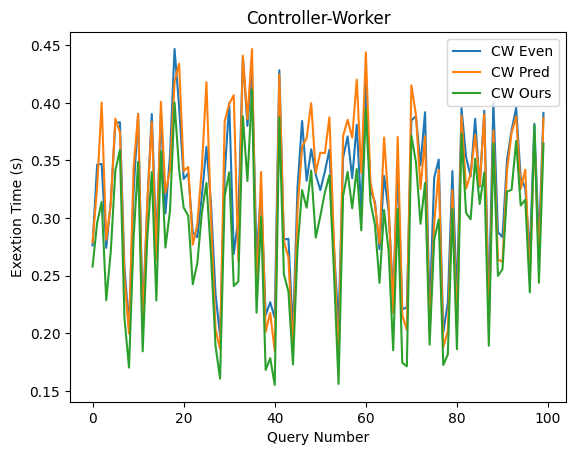

In [31]:
plt.plot(x, y_cw_even, label='CW Even')
plt.plot(x, y_cw_pred, label='CW Pred')
plt.plot(x, y_cw_our, label='CW Ours')

plt.legend()
plt.xlabel('Query Number')
plt.ylabel('Exextion Time (s)')
plt.title('Controller-Worker')

plt.show()

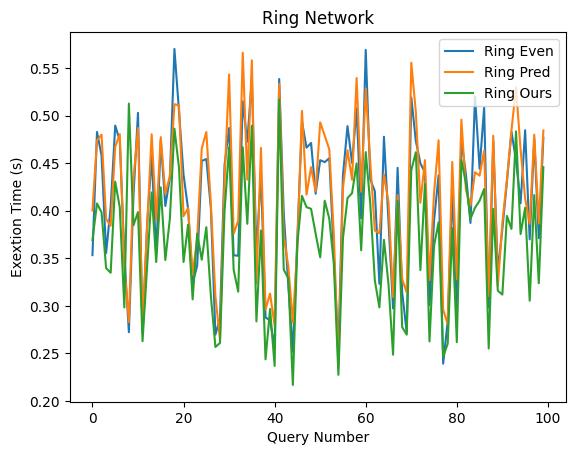

In [35]:
plt.plot(x, y_ring_even, label='Ring Even')
plt.plot(x, y_ring_pred, label='Ring Pred')
plt.plot(x, y_ring_our, label='Ring Ours')

plt.legend()
plt.xlabel('Query Number')
plt.ylabel('Exextion Time (s)')
plt.title('Ring Network')

plt.show()

Text(0.5, 1.0, 'Star Network')

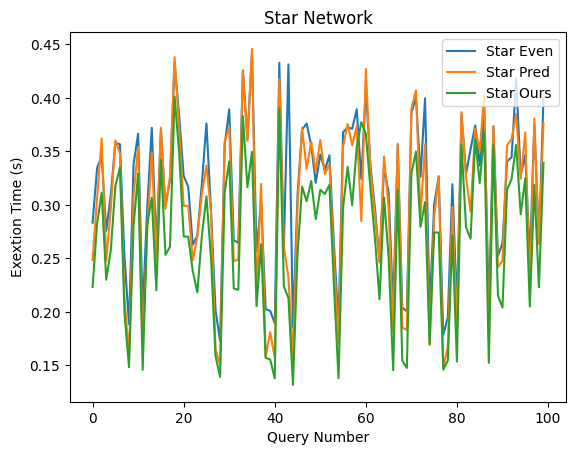

In [37]:

plt.plot(x, y_star_even, label='Star Even')
plt.plot(x, y_star_pred, label='Star Pred')
plt.plot(x, y_star_our, label='Star Ours')

plt.legend()
plt.xlabel('Query Number')
plt.ylabel('Exextion Time (s)')
plt.title('Star Network')